## Homework 5

### Подготовка

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Задание 1:
#### - Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.

In [16]:
# сгенерируем данные, представляющие собой 1000 объектов с 2 признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

In [17]:
list(zip(classification_data, classification_labels))

[(array([0.60103418, 1.5353525 ]), 1),
 (array([ 0.75594526, -1.1723519 ]), 0),
 (array([ 1.35447877, -0.94852841]), 0),
 (array([3.1030897 , 0.23348484]), 0),
 (array([0.75317779, 0.78751427]), 1),
 (array([1.0600389 , 0.58798641]), 1),
 (array([ 0.36855907, -1.35598715]), 0),
 (array([0.62515477, 0.91539778]), 1),
 (array([0.54901996, 1.45381422]), 1),
 (array([0.74616631, 1.08854866]), 1),
 (array([ 2.16500456, -0.36476962]), 0),
 (array([ 1.36702575, -0.71923613]), 1),
 (array([0.82265269, 1.28245544]), 1),
 (array([ 2.06431386, -0.28638103]), 0),
 (array([ 1.45941827, -0.78635092]), 0),
 (array([0.35523359, 1.5413809 ]), 1),
 (array([ 2.78403394, -0.02389532]), 0),
 (array([-0.89482916,  2.36200585]), 1),
 (array([ 2.11992066, -0.11793322]), 1),
 (array([-0.35445947, -1.86919202]), 0),
 (array([ 2.27550194, -0.51921062]), 0),
 (array([ 2.60450615, -0.65147855]), 0),
 (array([ 2.2870414 , -0.35983692]), 1),
 (array([ 0.39851903, -1.36229849]), 0),
 (array([0.36115471, 1.8250481 ]),

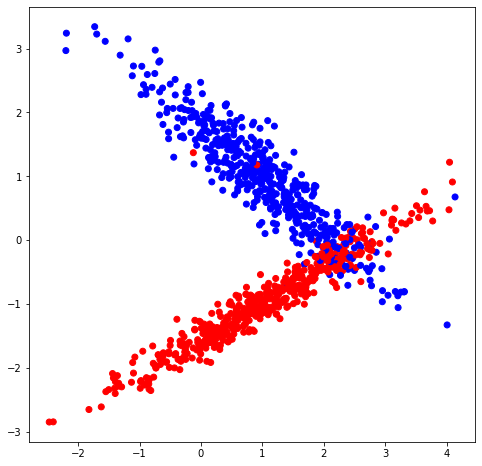

In [18]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).

In [19]:
def check_forest_accuracy(forest, train_data, test_data, train_labels, test_labels):
    train_answers = tree_vote(forest, train_data)
    test_answers = tree_vote(forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса на обучающей выборке: {train_accuracy:.3f}')
    print(f'Точность случайного леса на тестовой выборке: {test_accuracy:.3f}\n')
    return train_accuracy, test_accuracy

In [20]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)

In [21]:
forest_list = []
for n_trees in [1, 3, 10, 50, 100, 200]:
    my_forest = random_forest(train_data, train_labels, n_trees)
    print(f'Результаты для {n_trees} деревьев')
    train_accuracy, test_accuracy = check_forest_accuracy(my_forest, train_data, test_data, train_labels, test_labels)
    forest_list.append([my_forest, train_accuracy, test_accuracy])

Результаты для 1 деревьев
Точность случайного леса на обучающей выборке: 98.000
Точность случайного леса на тестовой выборке: 89.000

Результаты для 3 деревьев
Точность случайного леса на обучающей выборке: 98.286
Точность случайного леса на тестовой выборке: 92.333

Результаты для 10 деревьев
Точность случайного леса на обучающей выборке: 99.857
Точность случайного леса на тестовой выборке: 93.333

Результаты для 50 деревьев
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 93.000

Результаты для 100 деревьев
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 93.000

Результаты для 200 деревьев
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 93.667



#### - Визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [22]:
# Визуализируем леса на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

<ipython-input-23-98957e17fd4e>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-23-98957e17fd4e>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


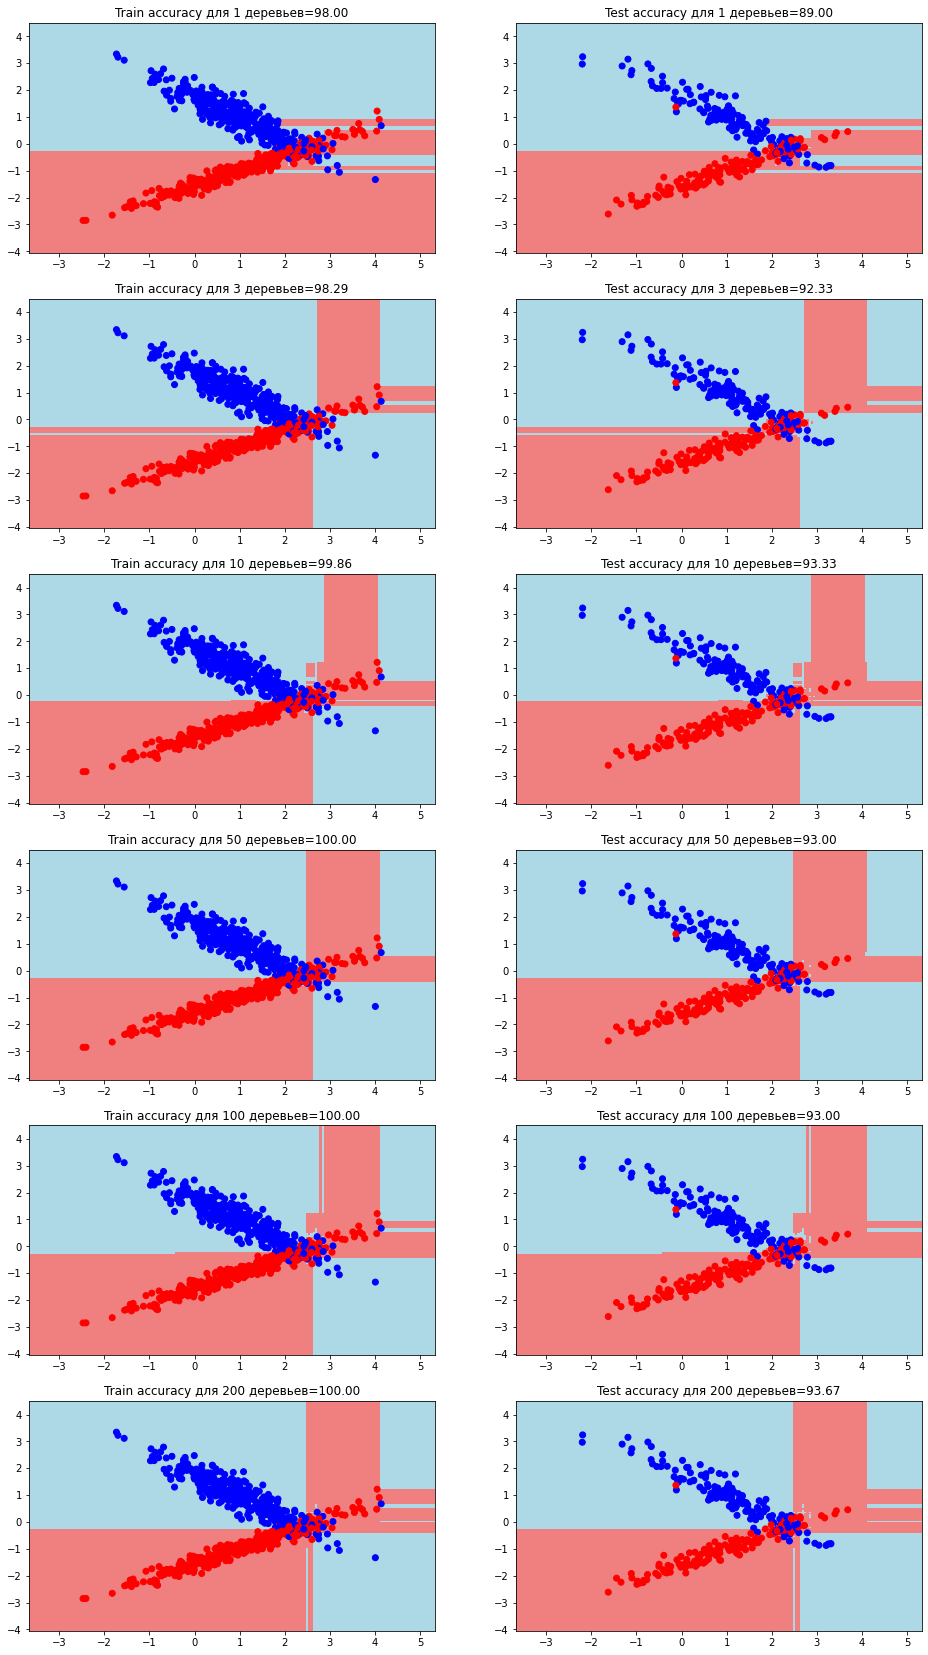

In [23]:
n_trees_list = [1, 3, 10, 50, 100, 200]

plt.figure(figsize = (16, 60))
for idx, n_trees in enumerate(n_trees_list, 1):
    # график обучающей выборки
    plt.subplot(len(n_trees_list)*2,2,idx*2-1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest_list[idx-1][0], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy для {n_trees} деревьев={forest_list[idx-1][1]:.2f}')

    # график тестовой выборки
    plt.subplot(len(n_trees_list)*2,2,idx*2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy для {n_trees} деревьев={forest_list[idx-1][2]:.2f}')

#### - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Визуально наиболее простыми графиками выглядит решения для 3 и 50 деревьев, при этом по метрике accuracy прирост качества на тестовой выборке для модели, начиная с леса для 10 деревьев, отсутствует. Наиболее оптимальным выглядит подбор решения от 3 до 10 деревьев.

Решения с недообучением не просматриваются, т.к. разрыв в метрике качества между обучающей и тестовой выборкой для всех решений не такой большой.
Решение с 1 деревом переобучено на своей ограниченной по признакам и объектам выборке из-за применяемого алгоритма (количество объектов в листе = 1). Уровень переобучения снижается по мере увеличения количества деревьев, но с некоторого значения (в нашем случае с 10) начинает вновь расти, т.к. появляется все больше одинаковых по признакам и объектам деревьев, при этом также растет сложность и время работы модели, не приводя к улучшению её качества.

### 2. (*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [132]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        # список индексов, не вошедших в бутстрэп выборку
        out_of_bag_samples_indexes = list(range(0, n_samples - 1))
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            # удаляем из списка индексов индекс, вошедший в бутстрэп выборку
            if sample_index in out_of_bag_samples_indexes: out_of_bag_samples_indexes.remove(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        # включаем в вывод функции данные по out-of-bag выборке
        bootstrap.append((b_data, b_labels, data[out_of_bag_samples_indexes], labels[out_of_bag_samples_indexes]))
    return bootstrap

In [138]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    accuracy_out_of_bag = []

    for b_data, b_labels, oob_data, oob_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        # считаем accuracy по out-of-bag выборке
        accuracy = accuracy_metric(oob_labels, predict(oob_data, tree))
        # добавляем accuracy в список
        accuracy_out_of_bag.append(accuracy)
    # устредняем oob-accuracy по лесу
    oob_score_ = np.array(accuracy_out_of_bag).mean()
    
    return forest, oob_score_

In [135]:
# проверяем работу
forest_list = []
for n_trees in [1, 3, 10, 50, 100, 200]:
    my_forest, oob_score_ = random_forest(train_data, train_labels, n_trees)
    print(f'Результаты для {n_trees} деревьев\noob_score_ = {oob_score_/100:.3f}')
    train_accuracy, test_accuracy = check_forest_accuracy(my_forest, train_data, test_data, train_labels, test_labels)
    forest_list.append([my_forest, train_accuracy, test_accuracy])

Результаты для 1 деревьев
oob_score_ = 0.909
Точность случайного леса на обучающей выборке: 96.571
Точность случайного леса на тестовой выборке: 92.667

Результаты для 3 деревьев
oob_score_ = 0.906
Точность случайного леса на обучающей выборке: 98.000
Точность случайного леса на тестовой выборке: 89.333

Результаты для 10 деревьев
oob_score_ = 0.916
Точность случайного леса на обучающей выборке: 99.429
Точность случайного леса на тестовой выборке: 93.000

Результаты для 50 деревьев
oob_score_ = 0.919
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 93.000

Результаты для 100 деревьев
oob_score_ = 0.916
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 94.000

Результаты для 200 деревьев
oob_score_ = 0.918
Точность случайного леса на обучающей выборке: 100.000
Точность случайного леса на тестовой выборке: 94.333

